## Analysis of publications related to OpenNeuro

In [20]:

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

datadir = '../data/openneuro'
figdir = '../figures'


In [10]:
metadata = pd.read_csv(os.path.join(datadir, 'metadata_06172021.csv'), skiprows=1)

In [11]:
metadata.columns

Index(['Assession Number', 'Dataset URL', 'Dataset name',
       'Dataset made public (MM/DD/YYYY)',
       'Most recent snapshot date (MM/DD/YYYY)', '# of subjects',
       'Modalities available?', 'DX status(es)', 'Ages (range)',
       'Tasks completed?', '# of trials (if applicable)', 'Study design',
       'Domain studied', 'Longitudinal?', 'Processed data?', 'Species?',
       'DOI of paper associated with DS (from submitter lab)',
       'DOI of paper because DS on OpenNeuro',
       'Senior Author (lab that collected data) Last, First'],
      dtype='object')

In [12]:
metadata['Dataset made public (MM/DD/YYYY)'] = pd.to_datetime(metadata['Dataset made public (MM/DD/YYYY)'])

In [13]:
data_paper_dois = metadata['DOI of paper associated with DS (from submitter lab)'].unique()
print(f'Number of data paper DOIs: {data_paper_dois.shape[0]}')

Number of data paper DOIs: 371


In [14]:
user_paper_dois = metadata['DOI of paper because DS on OpenNeuro'].unique()
print(f'Number of user paper DOIs: {user_paper_dois.shape[0]}')

Number of user paper DOIs: 29


Clean up data to create plots

In [15]:
df_sorted = metadata.sort_values('Dataset made public (MM/DD/YYYY)')
df_sorted['ones'] = 1
df_sorted['cumulative'] = df_sorted['ones'].cumsum()
df_sorted['cumulative_subjects'] = df_sorted['# of subjects'].cumsum()

Plot # of datasets over time

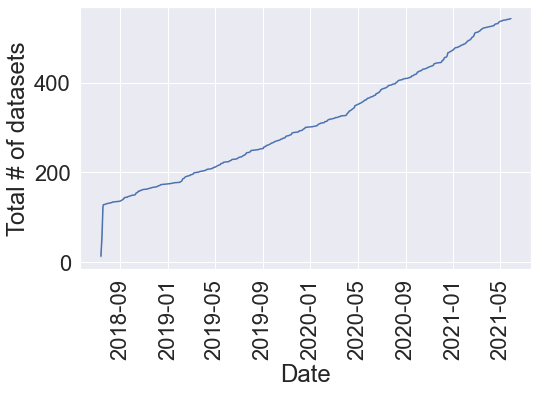

In [16]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2)  # crazy big
sns.lineplot(x='Dataset made public (MM/DD/YYYY)', y='cumulative', data=df_sorted)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Total # of datasets')
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'n_datasets.pdf'))

Plot # of subjects over time

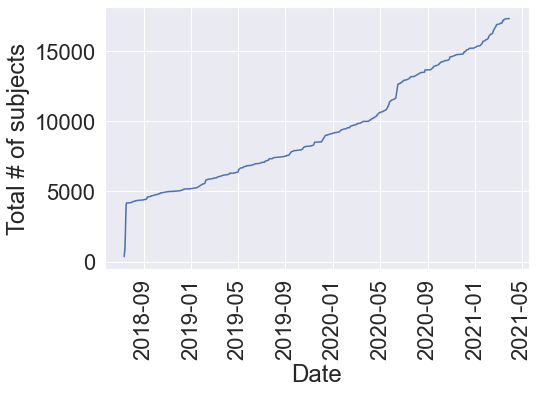

In [80]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2)  # crazy big
sns.lineplot(x='Dataset made public (MM/DD/YYYY)', y='cumulative_subjects', data=df_sorted)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Total # of subjects')
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'n_subjects.pdf'))

Plot both together

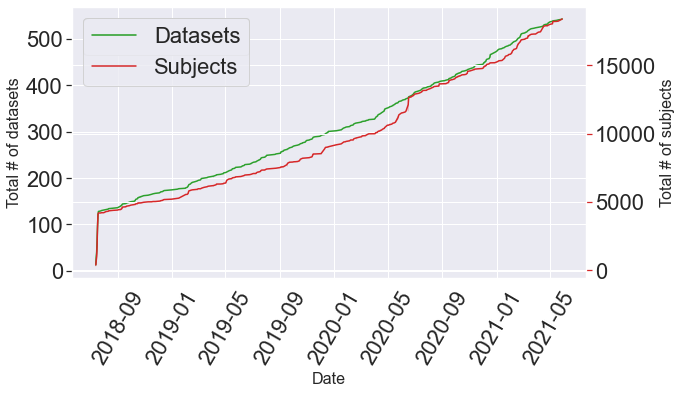

In [17]:
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Total # of datasets', fontsize=16) #, color=color)
ax1 = sns.lineplot(x='Dataset made public (MM/DD/YYYY)', y='cumulative', 
                    data=df_sorted, color=color, label='Datasets')
ax1.tick_params(axis='y')
plt.xticks(rotation=60)
#ax1.legend()

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total # of subjects', fontsize=16) #, color=color)
ax2 = sns.lineplot(x='Dataset made public (MM/DD/YYYY)', y='cumulative_subjects',
                   data=df_sorted, color=color, label='Subjects')
ax2.tick_params(axis='y', color=color)
#ax2.legend(loc=1)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.tight_layout()

plt.savefig(os.path.join(figdir, 'combined_growth.png'))

## analysis of data types: species

In [21]:
# clean up labels
cleanup_dict = {'Mice': 'Mouse',
               'Rats': 'Rat',
                'Adult Wistar rats': 'Rat',
               'C57bl/6 mixed gender mice': 'Mouse',
               'mouse': 'Mouse',
               'Macaque': 'NHP',
               'mouse lemur': 'NHP'}

species_counts_clean = {'Mouse': 0,
                        'Rat': 0,
                       'Human': 0,
                       'Phantom': 0,
                       'NHP': 0}

df_sorted['species'] = ''

for idx in df_sorted.index:
    if df_sorted.loc[idx,'Species?'] in cleanup_dict:
        df_sorted.loc[idx, 'species'] = cleanup_dict[df_sorted.loc[idx,'Species?']]
    else:
        df_sorted.loc[idx, 'species'] = df_sorted.loc[idx,'Species?']

species_counts = df_sorted['species'].value_counts()
for i in range(species_counts.loc['Mice and Rats']):
    species_counts.loc['Mouse'] = species_counts.loc['Mouse'] + 1
    species_counts.loc['Rat'] = species_counts.loc['Rat'] + 1
species_counts.drop('Mice and Rats', inplace=True)
species_counts

Human            512
Mouse             17
Rat                4
NHP                2
phantoms           1
rat                1
Juvenile pigs      1
Name: species, dtype: int64

In [22]:
species_counts/species_counts.sum()

Human            0.951673
Mouse            0.031599
Rat              0.007435
NHP              0.003717
phantoms         0.001859
rat              0.001859
Juvenile pigs    0.001859
Name: species, dtype: float64

## analysis of data types: modality

In [23]:

modalities = df_sorted['Modalities available?'].dropna()

mod_list = defaultdict(lambda: 0)

for i in modalities:
    for k in i.split(','):
        k = k.lstrip().lower()
        mod_list[k] = mod_list[k] + 1

In [24]:
mod_df = pd.Series(mod_list)
mod_df.sort_values(ascending=False)

mri - anat     463
mri - func     411
field map       70
eeg             61
mri - dwi       52
fieldmap        35
meg             20
beh             10
pet              8
ieeg             7
asl              3
fmap             2
ute              1
dixon            1
field map        1
calibration      1
fieldmaps        1
swi              1
eyetrack         1
stat             1
angiography      1
venograms        1
angiograms       1
motion           1
dtype: int64

## Analysis of dataset size

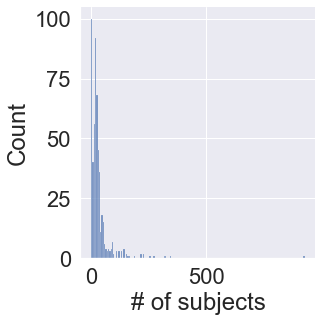

In [26]:
# number of subjects
import numpy as np
df_sorted['nsubs'] = df_sorted['# of subjects']
nsubs = df_sorted.query('nsubs > 0')['# of subjects']
sns.displot(nsubs) #, log_scale=True)

In [27]:
print('median # of subjects:', nsubs.median())


median # of subjects: 22.0


In [28]:
print('# of datasets with more than 100 subjects', (nsubs > 100).sum())

# of datasets with more than 100 subjects 28


In [29]:
print('maximum dataset size:', nsubs.max())

maximum dataset size: 928


## Analysis of publications

In [33]:
print('Proportion of papers with a DOI:',
      df_sorted['DOI of paper associated with DS (from submitter lab)'].dropna().shape[0]/df_sorted.shape[0])

Proportion of papers with a DOI: 0.7219152854511971


In [39]:
dois = []
multi_doi = 0
for i in df_sorted['DOI of paper associated with DS (from submitter lab)'].dropna():
    i_s = i.split(',')
    if len(i_s) > 1:
        multi_doi += 1
    dois = dois + i_s
    
print('# of papers associated with more than one DOI:', multi_doi)
print('# of unique DOIs:', len(set(dois)))

# of papers associated with more than one DOI: 65
# of unique DOIs: 564
